<a href="https://colab.research.google.com/github/chavgova/My-AI/blob/master/Female%20Previous%20Experiments/emotion_recognition_18_female_8features_realVoices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **DATA**





In [ ]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
from matplotlib.axis import Axis
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix
from keras import regularizers
import os
import pandas as pd


In [ ]:
from google.colab import drive
import os

path = '/content/drive/MyDrive/My_AI/Voice samples-Stela&Gabriela'

mylist = []
mylist = os.listdir(path)

print(mylist)	
print(len(mylist))

In [ ]:
# removing silence
#sox /content/drive/MyDrive/My_AI/Real voice evaluation samples/Gabriela-angry-10.m4a /content/try1.m4a silence -1 1 0.3 1% -1 2.0 1%

# LABLES & FEATURES

In [ ]:
import re

feeling_list=[]
dataset = ''
count = 0
for item in mylist:
  name_list = item.split('-')
  file_label = name_list[1]
  if file_label == 'neutral': feeling_list.append('female_neutral')
  elif file_label == 'angry': feeling_list.append('female_anger')
  elif file_label == 'disgust': feeling_list.append('female_disgust')
  elif file_label == 'surprise': feeling_list.append('female_surprise')
  elif file_label == 'joy': feeling_list.append('female_joy')
  elif file_label == 'sad': feeling_list.append('female_sadness')
  elif file_label == 'fear': feeling_list.append('female_fear')
  elif file_label == 'calm': feeling_list.append('female_calm')



In [ ]:
import pandas as pd

labels = pd.DataFrame(feeling_list)
labels

,0
0,female_anger
1,female_anger
2,female_anger
3,female_anger
4,female_anger
...,...
73,female_fear
74,female_fear
75,female_fear
76,female_surprise


Getting the features of audio files using librosa

In [ ]:
import librosa
import numpy as np

def reshape_feature(arr):   # reshapes to 10 values per feature
  shape_arr = arr.shape[0]
  r = shape_arr%10
  arr = arr[:(len(arr)-r)]
  d = int(shape_arr/10)
  arr = np.mean(arr.reshape(-1, d), axis=1) 
  return arr


def extract_feature(my_file, **kwargs):
    mfcc = kwargs.get("mfcc")
    chroma = kwargs.get("chroma")
    mel = kwargs.get("mel")
    contrast = kwargs.get("contrast")
    tonnetz = kwargs.get("tonnetz")
    rolloff = kwargs.get("rolloff")
    centroids = kwargs.get("centroids")
    rms = kwargs.get("rms")

    X, sample_rate = librosa.core.load(my_file)

    if chroma or contrast:
        stft = np.abs(librosa.stft(X))
    result = np.array([])
    if mfcc:
        mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
        result = np.hstack((result, mfccs))  # (n=40,t) -> 40 values 
    if rms:    
        rms = np.mean(librosa.feature.rms(X),axis=0)
        rms = reshape_feature(rms)      # (1,t) - > 10 values (avg)
        result = np.hstack((result, rms))        
    if mel:
        mel = np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
        result = np.hstack((result, mel))  # (128,t) -> 128 values   
    if tonnetz:
        tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X), sr=sample_rate).T,axis=0)
        result = np.hstack((result, tonnetz)) # (6,t) -> 6 values     
    if chroma:
        chroma = np.mean(librosa.feature.chroma_stft(S=stft, n_chroma = 14, sr=sample_rate).T,axis=0)
        result = np.hstack((result, chroma))  # (n=14,t) -> 14 values                      
    if contrast:
        contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T,axis=0)
        result = np.hstack((result, contrast))  # (7,t) -> 7 values
    if rolloff:    
        rolloff = np.mean(librosa.feature.spectral_rolloff(X+0.01, sr=sample_rate),axis=0)
        rolloff = reshape_feature(rolloff)    # (1,t) - > 10 values (avg)
        result = np.hstack((result, rolloff)) 
    if centroids:    
        centroids = np.mean(librosa.feature.spectral_centroid(X, sr=sample_rate),axis=0)
        centroids = reshape_feature(centroids)  # (1,t) - > 10 values (avg)
        result = np.hstack((result, centroids)) 
    
    return result

f = os.fspath('/content/drive/MyDrive/My_AI/Voice samples-Stela&Gabriela/Gabriela-angry-10.m4a')
a = extract_feature(f, mel=True, mfcc=True, contrast=True, chroma=True, tonnetz=True, rolloff=True, centroids=True, rms=True)
print(a, a.shape)

[-2.99756046e+02  8.75786956e+01 -1.88126317e+01  1.04703611e+01
 -4.50858338e+00  9.66236509e-01 -6.07351879e+00 -1.68496308e+00
  4.43543848e+00 -2.34223875e+00 -4.23021030e+00 -5.62459615e+00
 -8.17218652e+00 -1.56701268e+00  1.03612885e+01  7.84316421e-01
 -6.42160350e-01 -1.69270763e+00 -4.40838187e+00 -4.98279783e+00
 -5.97398450e+00 -4.37930698e+00 -8.26058758e+00 -2.26647326e+00
 -2.00337762e+00 -3.21028573e+00  2.02336641e+00  2.34242737e+00
  5.26605200e-01  1.19538625e+00  2.65895394e+00  2.44808839e+00
  4.98620159e+00  4.45198609e+00  4.75068068e+00  4.05832106e+00
  1.43473621e+00  1.21065216e+00  2.73482018e+00  3.90692374e+00
  1.31725648e-03  7.43287499e-04  1.40564144e-01  2.10777521e-01
  2.30829313e-01  2.89173692e-01  3.91741812e-01  2.11130112e-01
  3.31633948e-02  1.07552495e-03  6.53126847e-02  2.47796979e-01
  1.83504855e-01  1.72099780e-01  3.43614910e-01  9.53689471e+00
  9.84245665e+01  4.50147791e+01  7.79134327e+00  1.69851645e+01
  3.87480665e+00  2.70454

EXTRACT FEATURES FROM THE FILES IN THE DATASETS

In [ ]:
data_frame = pd.DataFrame(columns=['all_features'])
bookmark=0

for index,y in enumerate(mylist):
      all_features_ndarray = extract_feature('/content/drive/MyDrive/My_AI/Voice samples-Stela&Gabriela/'+ y, mel=True, mfcc=True, contrast=True, chroma=True, tonnetz=True, rolloff=True, centroids=True, rms=True)
      data_frame.loc[bookmark] = [all_features_ndarray]
      bookmark=bookmark+1
      if bookmark%20==0: print(bookmark)

print(data_frame.shape)
        

20
40
60
(78, 1)


In [ ]:
data_frame

,all_features
0,"[-340.54262541877614, 82.17994748900163, -17.3..."
1,"[-357.2361022138231, 97.41224268144029, -6.326..."
2,"[-336.973347891027, 85.99693373789185, -14.268..."
3,"[-329.1188633552169, 95.69051470432011, -11.74..."
4,"[-319.22576942475996, 85.93668516740819, -11.3..."
...,...
73,"[-310.30106929282715, 75.89373807748176, -20.5..."
74,"[-359.4114516808468, 74.14449875479846, -17.78..."
75,"[-348.98868956514684, 71.05814648375589, -11.8..."
76,"[-363.87777660265215, 68.85629605569923, -6.69..."


In [ ]:
print(pd.DataFrame(data_frame['all_features']).shape)

(78, 1)


In [ ]:
data_frame = pd.DataFrame(data_frame['all_features'].values.tolist())
data_frame[:10]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224
0,-340.542625,82.179947,-17.331782,30.521850,-5.398571,6.676162,-10.161005,5.500868,6.817201,-5.294645,-6.970361,-3.066188,-3.211614,-4.693303,11.260588,-5.840575,-0.269124,1.658988,-3.834128,-2.222288,-7.927239,-5.245375,-10.483164,-2.523516,-1.498290,-4.538636,1.425089,-2.794756,-3.340834,1.134883,0.835202,0.712321,1.173540,1.412974,3.099146,3.941565,4.031515,1.648050,2.754824,3.798180,...,0.643394,0.579431,0.486306,0.467240,0.487075,0.554170,0.665059,0.681088,0.677913,0.604579,0.580629,0.553457,0.540950,23.096100,16.580002,16.547270,18.187545,19.384843,23.187613,39.088121,268.336839,2101.143705,2179.822716,4250.323017,1818.727464,2853.149414,4982.451923,2575.702374,2371.136944,282.416241,1067.650775,2479.744470,1656.039637,2108.174934,1021.161095,1798.330572,3242.486318,1329.260219,1901.242098,1162.036919
1,-357.236102,97.412243,-6.326813,8.759378,13.739399,2.230847,-1.255189,-0.570268,-4.018753,2.637653,-4.277692,-3.319769,0.690440,-1.641362,3.960512,2.032272,-0.204003,-4.849379,1.807103,-3.886895,-6.821732,0.399129,-7.287828,-4.996501,-3.439474,-0.580665,-0.129873,-1.599742,-0.982021,-1.577181,1.095468,1.662272,3.725656,0.447183,2.119886,4.539330,2.498663,4.409591,4.140383,3.091949,...,0.511401,0.470673,0.431199,0.461544,0.512590,0.576588,0.610353,0.602176,0.593906,0.547919,0.487050,0.489164,0.525535,21.666407,18.598649,18.792785,17.886882,20.181522,20.568836,37.026141,275.625000,195.952148,408.054199,1496.557617,1999.357910,1143.413086,1420.114746,1527.780762,176.572266,778.425293,1147.435686,1305.983179,855.025294,930.048435,990.884547,807.814116,942.692259,772.067382,900.350641,1439.298688
2,-336.973348,85.996934,-14.268979,19.945955,5.184346,1.851564,-0.290272,-6.709703,-6.021953,-2.164262,-0.840084,1.233293,-1.463518,2.459087,6.194718,-3.625701,3.287440,2.220619,-1.292223,-2.705884,-6.095905,-4.015282,-3.359681,-2.343674,-4.469961,-2.218520,-1.663768,0.943088,-1.226753,-2.326342,-0.045121,-1.034876,5.090682,3.317312,3.265065,3.096746,1.374015,4.223195,3.271978,2.267971,...,0.609623,0.586618,0.537502,0.526952,0.558341,0.529623,0.546956,0.632410,0.656458,0.642869,0.624368,0.539459,0.516685,22.633421,17.274917,19.015048,17.292250,18.594695,22.133322,35.533474,269.165039,1129.514382,1039.466442,2342.225231,3578.426847,2191.492809,1619.884144,1813.682972,275.037731,680.253462,689.335673,1928.285328,1148.668366,1342.296381,1671.088067,1118.182091,1093.577881,1024.805634,1156.153174,1132.374925
3,-329.118863,95.690515,-11.743342,8.059214,12.638198,0.140079,-8.998062,-5.055537,-1.226763,4.018536,-3.286558,-2.934273,2.178891,-1.632670,2.273522,2.938486,-2.068988,-7.088348,4.477354,-4.247581,-9.330474,2.246744,-6.347680,-2.738940,-0.855900,-0.228639,0.265261,-2.482298,-1.182771,-3.221391,-0.250779,-0.531679,0.191858,-2.033896,0.054722,3.033039,-1.377400,1.400283,1.062323,1.201550,...,0.578986,0.542041,0.540959,0.545910,0.523260,0.528779,0.543932,0.598476,0.595161,0.573333,0.569830,0.565914,0.505457,22.475642,16.940991,18.375701,16.900306,20.963190,22.084354,37.395515,174.060059,503.338623,1144.848633,1918.249512,1975.671387,2264.575195,1297.375488,1760.339355,503.338623,60.113525,1420.215371,1405.392073,1085.343230,1258.266565,1266.698786,1209.499855,870.573661,920.206522,1048.856122,1437.266447
4,-319.225769,85.936685,-11.317976,15.558852,9.580083,0.459845,-5.851778,-6.010941,-5.371222,-1.176023,-3.101121,-8.575154,-3.881108,-0.278933,0.587867,-0.374321,0.808430,-4.246903,-1.473468,-3.954084,-7.558068,-0.671214,-5.696291,-3.050719,-1.276361,-4.167876,-0.596771,-3.112134,-3.818620,-1.638933,-0.730882,-0.029589,0.064245,1.416922,2.167520,3.379194,3.010109,1.813947,2.468023,0.143989,...,0.587855,0.577886,0.510000,0.477090,0.481492,0.546110,0.617867,0.667116,0

In [ ]:
data_frame_labels = pd.concat([data_frame,labels], axis=1)
data_frame_labels = data_frame_labels.rename(index=str, columns={"0": "label"})
data_frame_labels    

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,0
0,-340.542625,82.179947,-17.331782,30.521850,-5.398571,6.676162,-10.161005,5.500868,6.817201,-5.294645,-6.970361,-3.066188,-3.211614,-4.693303,11.260588,-5.840575,-0.269124,1.658988,-3.834128,-2.222288,-7.927239,-5.245375,-10.483164,-2.523516,-1.498290,-4.538636,1.425089,-2.794756,-3.340834,1.134883,0.835202,0.712321,1.173540,1.412974,3.099146,3.941565,4.031515,1.648050,2.754824,3.798180,...,0.579431,0.486306,0.467240,0.487075,0.554170,0.665059,0.681088,0.677913,0.604579,0.580629,0.553457,0.540950,23.096100,16.580002,16.547270,18.187545,19.384843,23.187613,39.088121,268.336839,2101.143705,2179.822716,4250.323017,1818.727464,2853.149414,4982.451923,2575.702374,2371.136944,282.416241,1067.650775,2479.744470,1656.039637,2108.174934,1021.161095,1798.330572,3242.486318,1329.260219,1901.242098,1162.036919,female_anger
1,-357.236102,97.412243,-6.326813,8.759378,13.739399,2.230847,-1.255189,-0.570268,-4.018753,2.637653,-4.277692,-3.319769,0.690440,-1.641362,3.960512,2.032272,-0.204003,-4.849379,1.807103,-3.886895,-6.821732,0.399129,-7.287828,-4.996501,-3.439474,-0.580665,-0.129873,-1.599742,-0.982021,-1.577181,1.095468,1.662272,3.725656,0.447183,2.119886,4.539330,2.498663,4.409591,4.140383,3.091949,...,0.470673,0.431199,0.461544,0.512590,0.576588,0.610353,0.602176,0.593906,0.547919,0.487050,0.489164,0.525535,21.666407,18.598649,18.792785,17.886882,20.181522,20.568836,37.026141,275.625000,195.952148,408.054199,1496.557617,1999.357910,1143.413086,1420.114746,1527.780762,176.572266,778.425293,1147.435686,1305.983179,855.025294,930.048435,990.884547,807.814116,942.692259,772.067382,900.350641,1439.298688,female_anger
2,-336.973348,85.996934,-14.268979,19.945955,5.184346,1.851564,-0.290272,-6.709703,-6.021953,-2.164262,-0.840084,1.233293,-1.463518,2.459087,6.194718,-3.625701,3.287440,2.220619,-1.292223,-2.705884,-6.095905,-4.015282,-3.359681,-2.343674,-4.469961,-2.218520,-1.663768,0.943088,-1.226753,-2.326342,-0.045121,-1.034876,5.090682,3.317312,3.265065,3.096746,1.374015,4.223195,3.271978,2.267971,...,0.586618,0.537502,0.526952,0.558341,0.529623,0.546956,0.632410,0.656458,0.642869,0.624368,0.539459,0.516685,22.633421,17.274917,19.015048,17.292250,18.594695,22.133322,35.533474,269.165039,1129.514382,1039.466442,2342.225231,3578.426847,2191.492809,1619.884144,1813.682972,275.037731,680.253462,689.335673,1928.285328,1148.668366,1342.296381,1671.088067,1118.182091,1093.577881,1024.805634,1156.153174,1132.374925,female_anger
3,-329.118863,95.690515,-11.743342,8.059214,12.638198,0.140079,-8.998062,-5.055537,-1.226763,4.018536,-3.286558,-2.934273,2.178891,-1.632670,2.273522,2.938486,-2.068988,-7.088348,4.477354,-4.247581,-9.330474,2.246744,-6.347680,-2.738940,-0.855900,-0.228639,0.265261,-2.482298,-1.182771,-3.221391,-0.250779,-0.531679,0.191858,-2.033896,0.054722,3.033039,-1.377400,1.400283,1.062323,1.201550,...,0.542041,0.540959,0.545910,0.523260,0.528779,0.543932,0.598476,0.595161,0.573333,0.569830,0.565914,0.505457,22.475642,16.940991,18.375701,16.900306,20.963190,22.084354,37.395515,174.060059,503.338623,1144.848633,1918.249512,1975.671387,2264.575195,1297.375488,1760.339355,503.338623,60.113525,1420.215371,1405.392073,1085.343230,1258.266565,1266.698786,1209.499855,870.573661,920.206522,1048.856122,1437.266447,female_anger
4,-319.225769,85.936685,-11.317976,15.558852,9.580083,0.459845,-5.851778,-6.010941,-5.371222,-1.176023,-3.101121,-8.575154,-3.881108,-0.278933,0.587867,-0.374321,0.808430,-4.246903,-1.473468,-3.954084,-7.558068,-0.671214,-5.696291,-3.050719,-1.276361,-4.167876,-0.596771,-3.112134,-3.818620,-1.638933,-0.730882,-0.029589,0.064245,1.416922,2.167520,3.379194,3.010109,1.813947,2.468023,0.143989,...,0.577886,0.510000,0.477090,0.481492,0.546110,0.617867,0.667

# SAVE DATASET FEATURES AND LABELS 

In [ ]:
import pickle

with open('/content/drive/My Drive/My_AI/realVoiceEvaluation-Stela&Gabriela-mix1.pkl', 'wb') as f:
  pickle.dump(data_frame_labels, f)


# LOAD DATASET FEATURES AND LABELS 

In [ ]:
import pickle

with open('/content/drive/My Drive/My_AI/realVoiceEvaluation-Stela&Gabriela-mix1.pkl', 'rb') as f:
  data_frame_labels = pickle.load(f)

In [ ]:
data_frame_labels

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,0
0,-340.542625,82.179947,-17.331782,30.521850,-5.398571,6.676162,-10.161005,5.500868,6.817201,-5.294645,-6.970361,-3.066188,-3.211614,-4.693303,11.260588,-5.840575,-0.269124,1.658988,-3.834128,-2.222288,-7.927239,-5.245375,-10.483164,-2.523516,-1.498290,-4.538636,1.425089,-2.794756,-3.340834,1.134883,0.835202,0.712321,1.173540,1.412974,3.099146,3.941565,4.031515,1.648050,2.754824,3.798180,...,0.579431,0.486306,0.467240,0.487075,0.554170,0.665059,0.681088,0.677913,0.604579,0.580629,0.553457,0.540950,23.096100,16.580002,16.547270,18.187545,19.384843,23.187613,39.088121,268.336839,2101.143705,2179.822716,4250.323017,1818.727464,2853.149414,4982.451923,2575.702374,2371.136944,282.416241,1067.650775,2479.744470,1656.039637,2108.174934,1021.161095,1798.330572,3242.486318,1329.260219,1901.242098,1162.036919,female_anger
1,-357.236102,97.412243,-6.326813,8.759378,13.739399,2.230847,-1.255189,-0.570268,-4.018753,2.637653,-4.277692,-3.319769,0.690440,-1.641362,3.960512,2.032272,-0.204003,-4.849379,1.807103,-3.886895,-6.821732,0.399129,-7.287828,-4.996501,-3.439474,-0.580665,-0.129873,-1.599742,-0.982021,-1.577181,1.095468,1.662272,3.725656,0.447183,2.119886,4.539330,2.498663,4.409591,4.140383,3.091949,...,0.470673,0.431199,0.461544,0.512590,0.576588,0.610353,0.602176,0.593906,0.547919,0.487050,0.489164,0.525535,21.666407,18.598649,18.792785,17.886882,20.181522,20.568836,37.026141,275.625000,195.952148,408.054199,1496.557617,1999.357910,1143.413086,1420.114746,1527.780762,176.572266,778.425293,1147.435686,1305.983179,855.025294,930.048435,990.884547,807.814116,942.692259,772.067382,900.350641,1439.298688,female_anger
2,-336.973348,85.996934,-14.268979,19.945955,5.184346,1.851564,-0.290272,-6.709703,-6.021953,-2.164262,-0.840084,1.233293,-1.463518,2.459087,6.194718,-3.625701,3.287440,2.220619,-1.292223,-2.705884,-6.095905,-4.015282,-3.359681,-2.343674,-4.469961,-2.218520,-1.663768,0.943088,-1.226753,-2.326342,-0.045121,-1.034876,5.090682,3.317312,3.265065,3.096746,1.374015,4.223195,3.271978,2.267971,...,0.586618,0.537502,0.526952,0.558341,0.529623,0.546956,0.632410,0.656458,0.642869,0.624368,0.539459,0.516685,22.633421,17.274917,19.015048,17.292250,18.594695,22.133322,35.533474,269.165039,1129.514382,1039.466442,2342.225231,3578.426847,2191.492809,1619.884144,1813.682972,275.037731,680.253462,689.335673,1928.285328,1148.668366,1342.296381,1671.088067,1118.182091,1093.577881,1024.805634,1156.153174,1132.374925,female_anger
3,-329.118863,95.690515,-11.743342,8.059214,12.638198,0.140079,-8.998062,-5.055537,-1.226763,4.018536,-3.286558,-2.934273,2.178891,-1.632670,2.273522,2.938486,-2.068988,-7.088348,4.477354,-4.247581,-9.330474,2.246744,-6.347680,-2.738940,-0.855900,-0.228639,0.265261,-2.482298,-1.182771,-3.221391,-0.250779,-0.531679,0.191858,-2.033896,0.054722,3.033039,-1.377400,1.400283,1.062323,1.201550,...,0.542041,0.540959,0.545910,0.523260,0.528779,0.543932,0.598476,0.595161,0.573333,0.569830,0.565914,0.505457,22.475642,16.940991,18.375701,16.900306,20.963190,22.084354,37.395515,174.060059,503.338623,1144.848633,1918.249512,1975.671387,2264.575195,1297.375488,1760.339355,503.338623,60.113525,1420.215371,1405.392073,1085.343230,1258.266565,1266.698786,1209.499855,870.573661,920.206522,1048.856122,1437.266447,female_anger
4,-319.225769,85.936685,-11.317976,15.558852,9.580083,0.459845,-5.851778,-6.010941,-5.371222,-1.176023,-3.101121,-8.575154,-3.881108,-0.278933,0.587867,-0.374321,0.808430,-4.246903,-1.473468,-3.954084,-7.558068,-0.671214,-5.696291,-3.050719,-1.276361,-4.167876,-0.596771,-3.112134,-3.818620,-1.638933,-0.730882,-0.029589,0.064245,1.416922,2.167520,3.379194,3.010109,1.813947,2.468023,0.143989,...,0.577886,0.510000,0.477090,0.481492,0.546110,0.617867,0.667

## **SCALING - NORMALIZATION**

In [ ]:
data_array = data_frame_labels.iloc[:,:(data_frame_labels.shape[1]-1)].to_numpy()
print(data_array)

[[-340.54262542   82.17994749  -17.33178162 ... 1329.26021909
  1901.24209849 1162.03691873]
 [-357.23610221   97.41224268   -6.32681258 ...  772.06738211
   900.3506414  1439.29868794]
 [-336.97334789   85.99693374  -14.26897903 ... 1024.80563439
  1156.15317391 1132.37492492]
 ...
 [-348.98868957   71.05814648  -11.82196345 ... 1054.48836691
  1382.1012027  1491.5597151 ]
 [-363.8777766    68.85629606   -6.69037518 ... 3085.83145712
  1618.07671718 1200.56034326]
 [-305.94142336   70.72782617   -7.29247763 ... 1285.75320676
  1096.87168712 1088.49267199]]


In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(data_array)
data_array = scaler.transform(data_array)
print(data_array)

[[ 0.48188008 -0.13842988 -0.75268185 ...  0.02375438  1.51891472
  -0.59735055]
 [ 0.20747844  0.97449258  0.24854852 ... -0.87868184 -1.40316379
   0.74757102]
 [ 0.54055064  0.14045191 -0.47402855 ... -0.46934393 -0.65635445
  -0.74123282]
 ...
 [ 0.34304658 -0.95102588 -0.25139945 ... -0.42126941  0.00329538
   1.00107508]
 [ 0.09830487 -1.11190045  0.21547165 ...  2.86871827  0.69222021
  -0.41048387]
 [ 1.05064276 -0.97516019  0.16069247 ... -0.0467101  -0.82942533
  -0.95409372]]


REPLACING OLD VALUES WITH THE NORMALIZED ONES

In [ ]:
for w in range(0,data_array.shape[0]):
  data_frame_labels.iloc[w,:data_array.shape[1]] = data_array[w]
  
print(data_frame_labels.shape)

(78, 226)


In [ ]:
data_frame_labels

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,0
0,0.481880,-0.138430,-0.752682,0.691487,-0.862220,0.102973,-0.585828,1.597376,1.609449,-1.210737,-1.201788,0.406948,-1.323842,-1.518029,2.212440,-1.684038,-0.435583,0.267034,-1.119531,-0.202696,-1.347387,-1.368588,-2.592440,-1.327216,-0.302483,-1.456845,0.225744,-1.246564,-1.264789,0.626994,-0.383492,0.076001,-0.244644,0.311016,0.989831,1.245661,1.875983,0.407893,1.125245,1.814165,...,0.538503,-0.060439,-0.074580,0.090036,0.495209,1.283176,1.255456,1.175247,0.056758,-0.098457,-0.133166,0.245851,1.750301,-0.268936,-1.254275,0.422356,-0.162564,2.144185,1.552239,-0.514183,1.172485,0.335191,1.827522,-0.920978,0.354933,2.054060,0.909178,2.694937,-0.585012,-1.117935,2.929226,0.764813,1.304246,-0.990379,0.586084,2.538282,0.023754,1.518915,-0.597351,female_anger
1,0.207478,0.974493,0.248549,-1.315709,1.458382,-0.453890,0.712311,0.516828,-1.030851,0.602818,-0.577246,0.354781,-0.157094,-0.663733,-0.162237,0.494864,-0.420046,-1.579813,0.858080,-0.625762,-1.019205,0.238003,-1.700347,-2.301374,-0.984129,-0.319466,-0.412501,-0.700594,-0.331485,-0.756258,-0.256417,0.542788,0.667480,-0.147650,0.529221,1.553473,1.095987,1.587245,1.895236,1.388279,...,-0.900920,-0.832492,-0.151963,0.406918,0.757583,0.631649,0.220843,-0.018467,-0.884110,-2.008132,-1.357461,-0.016006,1.098992,1.069771,0.268460,0.144888,0.515951,0.356803,0.170797,-0.503483,-0.937439,-1.217573,-1.198628,-0.735844,-1.280611,-0.746218,-0.007448,-0.722426,1.030726,-0.829932,-0.648033,-1.283349,-1.274042,-1.052722,-1.073258,-0.763719,-0.878682,-1.403164,0.747571,female_anger
2,0.540551,0.140452,-0.474029,-0.283949,0.421027,-0.501403,0.852961,-0.575877,-1.518953,-0.495040,0.220078,1.291445,-0.801146,0.484061,0.564539,-1.071046,0.412948,0.426405,-0.228431,-0.325604,-0.803735,-1.018468,-0.603664,-1.256372,-1.345983,-0.790127,-1.042099,0.461158,-0.428318,-1.138357,-0.813310,-0.782536,1.155338,1.215410,1.067874,0.810632,0.523708,1.507642,1.412640,0.891388,...,0.633632,0.656818,0.736556,0.975116,0.207908,-0.123382,0.617242,0.870376,0.692580,0.794122,-0.399715,-0.166337,1.539524,0.191911,0.419182,-0.403868,-0.835517,1.424605,-0.829228,-0.512967,0.096444,-0.664208,-0.269312,0.882600,-0.278011,-0.589184,0.242633,-0.569097,0.710934,-2.483556,1.248550,-0.532515,-0.371852,0.347888,-0.553321,-0.547081,-0.469344,-0.656354,-0.741233,female_anger
3,0.669660,0.848697,-0.244247,-1.380287,1.324855,-0.715800,-0.416314,-0.281466,-0.350552,0.918528,-0.347361,0.434086,0.287965,-0.661300,-0.711006,0.745669,-0.864998,-2.215154,1.794173,-0.717432,-1.763954,0.763888,-1.437871,-1.412075,-0.076908,-0.218306,-0.250316,-1.103810,-0.410916,-1.594864,-0.913722,-0.535275,-0.595496,-1.325945,-0.442161,0.777826,-0.876356,0.302080,0.184678,0.248294,...,0.043640,0.705250,0.994090,0.539432,0.198035,-0.159394,0.172333,-0.000647,-0.462106,-0.318845,0.104056,-0.357059,1.467646,-0.029539,-0.014374,-0.765574,1.181682,1.391182,0.418262,-0.652597,-0.597021,-0.571852,-0.735225,-0.760121,-0.208100,-0.842701,0.195973,-0.213588,-1.309158,0.154733,-0.345066,-0.694435,-0.555748,-0.484792,-0.400342,-0.867266,-0.638754,-0.969606,0.737713,female_anger
4,0.832279,0.136050,-0.205547,-0.688580,0.954039,-0.675743,0.042298,-0.451510,-1.360395,-0.269100,-0.304350,-0.726366,-1.524026,-0.282363,-1.259341,-0.171189,-0.178499,-1.408852,-0.291969,-0.642838,-1.237795,-0.066648,-1.256013,-1.534891,-0.224552,-1.350302,-0.604143,-1.391566,-1.453833,-0.787753,-1.148133,-0.288558,-0.641104,0.312891,0.551627,0.956075,1.356238,0.478741,0.965862,-0.389458,...,0.518063,0.271515,0.059218,0.020696,0.400872,0.721140,1.072271,1.767263,0.314738,-0.333271,-0.134249,-0.376895,1.689573,0.121443,0.026718,-0.556007,-0.133367,1.256467,-1.309624,-0.622037,-0.758586,-0.412702,-0.607050,0.311385,-0.697665,

# **SAVE NORMALIZED DATAFRAME**

In [ ]:
import pickle

with open('/content/drive/My Drive/My_AI/realVoiceEvaluation-Stela&Gabriela-mix1_normalized.pkl', 'wb') as f:
  pickle.dump(data_frame_labels, f)

# **LOAD NORMALIZED DATAFRAME**

In [ ]:
import pickle

with open('/content/drive/My Drive/My_AI/realVoiceEvaluation-Stela&Gabriela-mix1_normalized.pkl', 'rb') as f:
  data_frame_labels = pickle.load(f)


# Dividing the data into test and train

In [ ]:
import numpy as np

data_frame_labels.rename(columns={'0': 'lables'}, inplace=True)
data_frame_labels = data_frame_labels.dropna(axis=1) 
columns_arr = [i for i in range(225)]
columns_arr.append('lables')
data_frame_labels.columns = columns_arr

print(data_frame_labels)

data_frame_labels_set = np.random.rand(len(data_frame_labels)) < 1.01

test = data_frame_labels[data_frame_labels_set]


           0         1         2  ...       223       224           lables
0   0.481880 -0.138430 -0.752682  ...  1.518915 -0.597351     female_anger
1   0.207478  0.974493  0.248549  ... -1.403164  0.747571     female_anger
2   0.540551  0.140452 -0.474029  ... -0.656354 -0.741233     female_anger
3   0.669660  0.848697 -0.244247  ... -0.969606  0.737713     female_anger
4   0.832279  0.136050 -0.205547  ...  0.164811 -0.173674     female_anger
..       ...       ...       ...  ...       ...       ...              ...
73  0.978980 -0.597721 -1.042115  ...  0.488410  4.368591      female_fear
74  0.171721 -0.725527 -0.794242  ...  1.415266  0.337421      female_fear
75  0.343047 -0.951026 -0.251399  ...  0.003295  1.001075      female_fear
76  0.098305 -1.111900  0.215472  ...  0.692220 -0.410484  female_surprise
77  1.050643 -0.975160  0.160692  ... -0.829425 -0.954094  female_surprise

[78 rows x 226 columns]


In [ ]:
from sklearn.utils import shuffle

test = shuffle(test)
test

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,lables
10,-1.310237,0.749185,1.494764,0.505731,0.434533,1.140112,0.889408,0.327150,0.932041,1.312534,0.317840,0.496168,0.960142,-0.015280,-0.341860,0.087475,-0.383675,-1.163698,0.553196,0.299740,-0.425207,-0.847466,-0.693976,0.266406,-0.074308,0.367344,-0.598225,-1.161468,-0.554755,-0.043080,1.357687,2.115118,3.238815,3.162805,1.078481,-0.550818,-1.653647,-0.088360,-0.297846,-0.387570,...,-0.811315,-0.750189,-0.047888,-0.361861,-0.472257,0.005269,0.686852,1.557879,2.068782,-0.158878,-1.427128,-1.494638,0.321555,0.508864,-0.531480,0.305023,-0.593543,-0.848008,0.018598,-0.817953,-1.009261,0.390780,-0.699614,1.421254,-1.018522,-1.065488,-1.092859,-0.850437,-1.286293,-0.168853,-0.886248,-0.568577,-0.533964,1.744509,-0.529810,-1.037227,-0.453264,-0.273184,0.266692,female_calm
41,0.902671,-2.054729,-0.350844,0.481958,-0.636234,-1.062351,-1.325954,-0.695746,-1.813038,0.464620,-0.458870,-0.906726,0.235725,-0.177050,0.459044,0.637102,2.159774,0.948260,1.703070,1.330380,0.412589,1.985038,1.199946,0.013752,-0.151022,0.433015,-1.017208,0.171701,0.876613,0.270290,0.788641,-1.051987,-0.679093,-0.952369,0.055705,-0.354960,-0.884935,-0.129754,-0.137574,0.232920,...,-0.451600,-0.342399,-0.239378,-0.634630,-0.894960,-0.735714,-0.754740,-0.888345,0.102379,0.796284,0.995689,0.452446,-0.870178,0.859252,0.972805,0.423394,0.267687,0.369578,1.164657,0.778832,1.054064,0.883352,0.360509,1.655334,1.374002,0.514734,-0.233053,-0.672316,-0.002727,1.023732,-0.000197,-0.133739,0.154858,1.476225,1.433910,0.299091,0.555317,0.514779,-0.424521,female_joy
7,-0.843572,0.039638,1.470498,1.939556,0.802580,0.980644,-0.056192,0.410813,1.002139,0.446332,0.050551,-0.536793,1.309646,0.549540,-0.177078,1.153532,-0.061124,-1.243967,0.143105,0.635988,-0.539917,-1.240638,0.412748,1.179889,0.950587,1.875748,0.827718,-0.456991,-0.413506,-0.050504,-0.366165,-0.520423,1.182612,0.408728,-0.772990,-0.794164,-0.278912,-0.001744,-0.452431,-0.986627,...,0.742013,-0.227618,-1.060357,-1.028472,-0.701900,-0.280674,0.407024,1.509159,0.839963,0.476735,0.222285,-0.427344,0.182230,-0.173590,0.511147,-0.154584,-0.715576,-1.079323,0.592876,-0.172234,0.149859,0.664233,-0.325064,1.958799,1.018100,0.308321,0.197542,-0.880024,-1.072422,-0.802166,-0.921576,-0.379256,-0.724641,2.678277,0.662216,0.033733,0.137381,-0.165470,-0.013220,female_calm
53,-1.280154,-0.381046,0.357333,-0.975394,1.019001,0.460634,1.650200,0.451507,0.917380,0.301024,1.148166,2.169310,-0.900395,1.011336,0.018205,-0.970561,0.165143,-0.320424,-0.449511,0.038246,0.061491,-0.478256,-0.377100,-0.487373,1.168402,1.033295,0.961460,0.992903,0.105960,0.245304,-0.942085,0.039141,0.973985,0.921063,1.145292,0.840523,0.597245,1.088960,1.392771,1.493561,...,0.314335,0.951060,0.821397,0.585994,0.936537,0.519010,0.151491,0.358668,-0.314053,-0.360820,-0.440199,0.772175,0.425553,-0.562583,-0.293241,-0.515698,-0.585837,-0.354592,-1.076032,-0.629263,-1.003700,-1.212585,-1.124258,-1.114031,-0.790507,-0.423158,-0.733683,-0.920740,0.544228,-0.497777,-0.358417,0.499988,0.361637,-0.841613,-0.851819,-0.581520,-0.174007,0.482797,-0.112342,female_neutral
11,-1.356654,1.011585,1.549530,-0.119463,0.773629,0.584510,0.919726,0.323582,0.904491,1.405313,0.309382,0.632346,0.658982,0.133783,0.611311,0.795284,-0.610123,-0.562253,0.596081,0.120751,0.001670,-0.849189,-0.587632,-0.084313,0.011859,0.428989,-0.412312,-1.277080,-0.662515,-0.001916,0.433331,1.266570,2.377686,2.891620,1.835028,1.209046,-0.055191,-0.042699,-0.520304,-0.583796,...,-1.228672,-0.874633,-0.732501,-0.895151,-0.609878,-0.408548,0.445194,2.997977,1.676020,-0.192586,-1.551034,-1.960291,0.476201,0.393235,0.312077,1.230725,-0.200158,-0.692758,-0.806868,-0.776110,-0.665582,0.172093,-0.804707,-1.826304,-1.456549,-0.849920,-1.293954,-0.

In [ ]:
testfeatures = test.iloc[:, :-1]
testlabel = test.iloc[:, -1:]
testlabel

,lables
10,female_calm
41,female_joy
7,female_calm
53,female_neutral
11,female_calm
...,...
5,female_calm
39,female_joy
6,female_calm
32,female_neutral


In [ ]:
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder

X_test = np.array(testfeatures)
y_test = np.array(testlabel)

lb = LabelEncoder()
y_test = np_utils.to_categorical(lb.fit_transform(y_test))


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
y_test

array([[0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 

In [ ]:
X_test

array([[-1.49155373,  0.43002874,  1.56645087, ..., -0.08030689,
        -0.41367114, -0.11821896],
       [-0.15747101,  0.21484167, -0.37110049, ...,  1.26738439,
         1.02023079,  0.53374187],
       [ 1.00068736, -1.40206666, -0.33309002, ...,  0.15736633,
         0.45460001,  0.14412127],
       ...,
       [ 0.54055064,  0.14045191, -0.47402855, ..., -0.46934393,
        -0.65635445, -0.74123282],
       [-0.92139669, -1.17390205,  1.14538666, ..., -0.45968217,
        -0.24614791, -1.18168701],
       [-1.37168513,  1.15716158,  1.22514402, ..., -0.36203283,
        -0.17350546, -0.23458078]])

Changing dimension for CNN model

In [ ]:
x_testcnn= np.expand_dims(X_test, axis=2)
print(x_testcnn)

[[[-1.49155373]
  [ 0.43002874]
  [ 1.56645087]
  ...
  [-0.08030689]
  [-0.41367114]
  [-0.11821896]]

 [[-0.15747101]
  [ 0.21484167]
  [-0.37110049]
  ...
  [ 1.26738439]
  [ 1.02023079]
  [ 0.53374187]]

 [[ 1.00068736]
  [-1.40206666]
  [-0.33309002]
  ...
  [ 0.15736633]
  [ 0.45460001]
  [ 0.14412127]]

 ...

 [[ 0.54055064]
  [ 0.14045191]
  [-0.47402855]
  ...
  [-0.46934393]
  [-0.65635445]
  [-0.74123282]]

 [[-0.92139669]
  [-1.17390205]
  [ 1.14538666]
  ...
  [-0.45968217]
  [-0.24614791]
  [-1.18168701]]

 [[-1.37168513]
  [ 1.15716158]
  [ 1.22514402]
  ...
  [-0.36203283]
  [-0.17350546]
  [-0.23458078]]]


# **MODEL**

In [ ]:
model = Sequential() 

model.add(Conv1D(225, kernel_size=5,padding='same', activation='tanh',kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4), input_shape=(225,1)))

model.add(Conv1D(128, kernel_size=5,padding='same', activation='tanh', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)))

model.add(Conv1D(128, kernel_size=5,padding='same', activation='tanh', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)))
model.add(Dropout(0.2))

model.add(Conv1D(64, kernel_size=5,padding='same', activation='tanh', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)))

model.add(Dense(units=64, activation='tanh',input_dim=2,kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)))
model.add(Dropout(0.2))

model.add(Conv1D(64, kernel_size=5,padding='same', activation='tanh', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)))

model.add(Flatten())

model.add(Dense(units=32, activation='tanh',kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)))
model.add(Dense(8))
model.add(Activation('softmax')) 

opt = tf.keras.optimizers.Adam(learning_rate=0.0001) ### 

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 225, 225)          1350      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 225, 128)          144128    
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 225, 128)          82048     
_________________________________________________________________
dropout (Dropout)            (None, 225, 128)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 225, 64)           41024     
_________________________________________________________________
dense (Dense)                (None, 225, 64)           4160      
_________________________________________________________________
dropout_1 (Dropout)          (None, 225, 64)           0

In [ ]:
model.compile(loss= 'categorical_crossentropy', optimizer = opt, metrics=['accuracy'])

In [ ]:
cnnhistory = model.fit(x_traincnn, y_train, batch_size = 32, epochs = 50, validation_data = (x_testcnn, y_test))

Epoch 1/50
120/120 [==============================] - 30s 249ms/step - loss: 1.3167 - accuracy: 0.6443 - val_loss: 1.0228 - val_accuracy: 0.7424
Epoch 2/50
120/120 [==============================] - 30s 249ms/step - loss: 0.9223 - accuracy: 0.7731 - val_loss: 0.8972 - val_accuracy: 0.7608
Epoch 3/50
120/120 [==============================] - 30s 248ms/step - loss: 0.8048 - accuracy: 0.8124 - val_loss: 0.8383 - val_accuracy: 0.7965
Epoch 4/50
120/120 [==============================] - 30s 248ms/step - loss: 0.7347 - accuracy: 0.8419 - val_loss: 0.7811 - val_accuracy: 0.8084
Epoch 5/50
120/120 [==============================] - 30s 248ms/step - loss: 0.6720 - accuracy: 0.8623 - val_loss: 0.7608 - val_accuracy: 0.8139
Epoch 6/50
120/120 [==============================] - 30s 248ms/step - loss: 0.6268 - accuracy: 0.8762 - val_loss: 0.7104 - val_accuracy: 0.8420
Epoch 7/50
120/120 [==============================] - 30s 248ms/step - loss: 0.5884 - accuracy: 0.8930 - val_loss: 0.6883 - val_ac

# **PLOTTING**

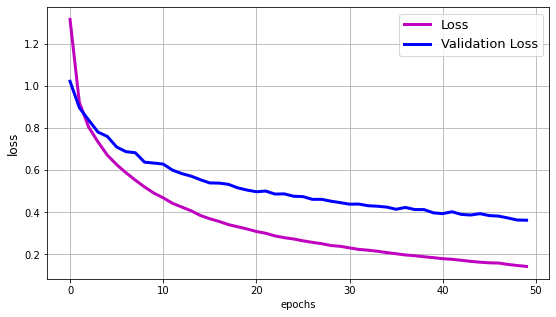

In [ ]:
plt.figure(figsize=(9,5))

plt.plot(cnnhistory.history['loss'], 'm', linewidth=3)
plt.plot(cnnhistory.history['val_loss'], 'b', linewidth=3)
plt.legend(['Loss', 'Validation Loss'], fontsize=13)
plt.xlabel('epochs')
plt.ylabel('loss', fontsize=12)
plt.grid(True)
plt.show()

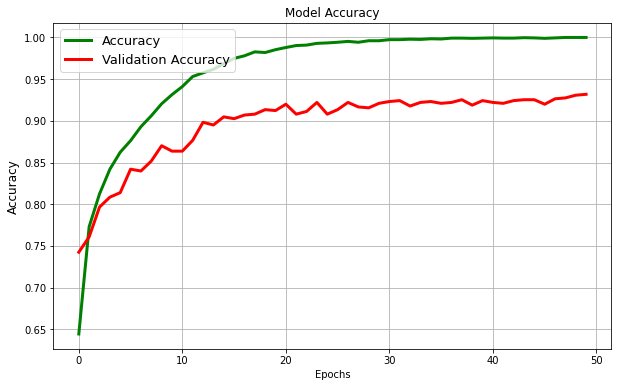

In [ ]:
plt.figure(figsize=(10,6), frameon=True)

plt.plot(cnnhistory.history['accuracy'], 'g', linewidth=3)
plt.plot(cnnhistory.history['val_accuracy'], 'r', linewidth=3)
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy', fontsize=12)

plt.legend(['Accuracy', 'Validation Accuracy'], loc = 'upper left', fontsize=13)
plt.grid(True)
plt.show()

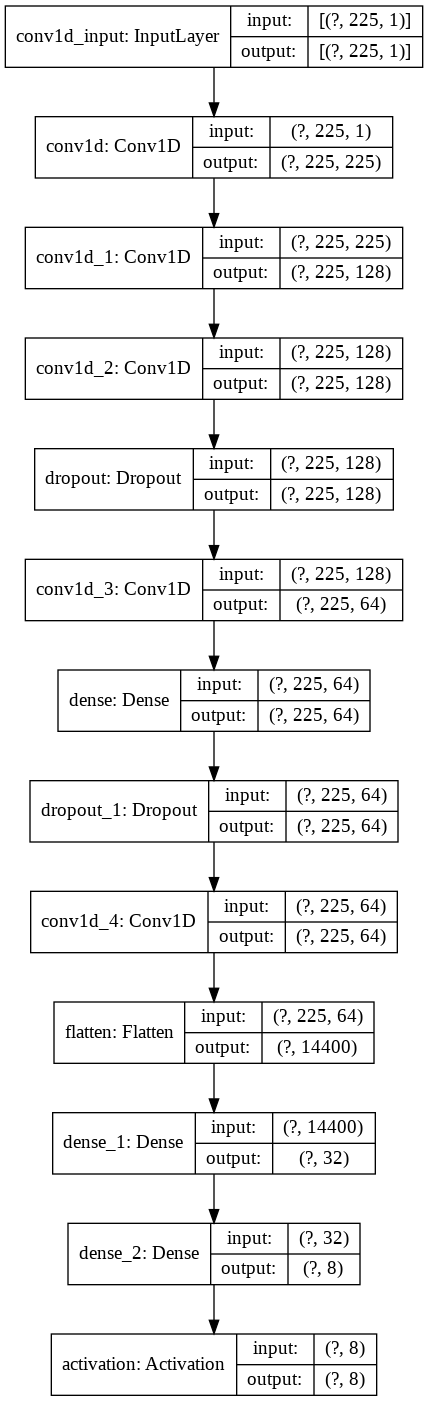

In [ ]:
tf.keras.utils.plot_model(
    model,
    to_file="img_model.png",
    show_shapes=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
)

dot_img_file = '/content/drive/My Drive/My_AI/img_model_FEMALE_8features_normalized_regularized.png'
tf.keras.utils.plot_model(model, to_file = dot_img_file, show_shapes=True)


# **SAVING THE MODEL**

In [ ]:
model_name = 'Emotion_Voice_Detection_CNN_model_18_FEMALE_8features_normalized_tanh_regularized.h5'
path = '/content/drive/My Drive/My_AI/MY MODELS/'
model_path = os.path.join(path, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at /content/drive/My Drive/My_AI/MY MODELS/Emotion_Voice_Detection_CNN_model_18_FEMALE_8features_normalized_tanh_regularized.h5 


In [ ]:
import json
model_json = model.to_json()
with open("/content/drive/My Drive/My_AI/MY MODELS/model_18_FEMALE_8features_normalized_tanh_regularized.json", "w") as json_file:
    json_file.write(model_json)

# **LOADING THE MODEL**

In [ ]:
import tensorflow as tf 
from keras.models import model_from_json
json_file = open('/content/drive/My Drive/My_AI/MY MODELS/model_18_FEMALE_8features_normalized_tanh_regularized.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("/content/drive/My Drive/My_AI/MY MODELS/Emotion_Voice_Detection_CNN_model_18_FEMALE_8features_normalized_tanh_regularized.h5")
print("Loaded model from disk")

# evaluate loaded model on test data
opt = tf.keras.optimizers.Adam(learning_rate=0.0001) ###
loaded_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
score = loaded_model.evaluate(x_testcnn, y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Loaded model from disk


NameError: ignored

# **Predicting emotions on the test data**


In [ ]:
import pandas as pd

preds = loaded_model.predict(x_testcnn, batch_size=32, verbose=1)
preds1=preds.argmax(axis=1)
print(preds1)
abc = preds1.astype(int).flatten()
predictions = (lb.inverse_transform((abc)))
preddf = pd.DataFrame({'predictedvalues': predictions})

actual=y_test.argmax(axis=1)

abc123 = actual.astype(int).flatten()
actualvalues = (lb.inverse_transform((abc123)))

actualdf = pd.DataFrame({'actualvalues': actualvalues})
finaldf = actualdf.join(preddf)

finaldf[:50]


3/3 [==============================] - 0s 65ms/step
[0 0 1 2 0 3 2 5 5 0 6 3 3 7 3 3 4 1 0 6 3 0 6 0 0 5 3 6 5 0 2 0 4 6 6 3 2
 3 4 1 4 3 7 3 0 6 7 4 6 3 4 0 6 6 6 2 0 2 3 2 5 2 2 6 3 3 5 5 7 0 4 6 5 1
 2 3 5 3]


,actualvalues,predictedvalues
0,female_surprise,female_anger
1,female_anger,female_anger
2,female_sadness,female_calm
3,female_disgust,female_disgust
4,female_fear,female_anger
5,female_fear,female_fear
6,female_anger,female_disgust
7,female_sadness,female_neutral
8,female_calm,female_neutral
9,female_joy,female_anger


In [ ]:
import pandas as pd
import numpy as np

def asarray(a, dtype=None, order=None):
    return np.array(a, dtype, copy=False, order=order)

preds = loaded_model.predict(x_testcnn, batch_size=32, verbose=1)
preds1 = preds.argmax(axis=1)
preds_top = np.argsort(preds)[:, -3:][:, ::3]
#preds_top = np.argsort(preds)[:, -2:][:, ::2] TOP 2
#preds_top = np.argsort(preds)[:, -3:][:, ::3]  TOP 3
#print(preds_top)
preds_top = preds_top.astype(int).flatten()
preds_top_list = []
for i in preds_top:
  preds_top_list.append(i)
preds_top_array = asarray(preds_top_list)
#print(preds_top_array)

predictions = (lb.inverse_transform((preds_top_array)))
preddf = pd.DataFrame({'predictedvalues': predictions})
#print(preddf)
actual=y_test.argmax(axis=1)

abc123 = actual.astype(int).flatten()
actualvalues = (lb.inverse_transform((abc123)))

actualdf = pd.DataFrame({'actualvalues': actualvalues})
finaldf = actualdf.join(preddf)

finaldf[:50]


3/3 [==============================] - 0s 63ms/step


,actualvalues,predictedvalues
0,female_surprise,female_fear
1,female_neutral,female_anger
2,female_anger,female_neutral
3,female_joy,female_sadness
4,female_anger,female_disgust
5,female_calm,female_calm
6,female_joy,female_sadness
7,female_surprise,female_sadness
8,female_anger,female_sadness
9,female_surprise,female_joy


In [ ]:
finaldf.groupby('actualvalues').count()

,predictedvalues
actualvalues,
female_anger,11
female_calm,9
female_disgust,8
female_fear,11
female_joy,10
female_neutral,10
female_sadness,9
female_surprise,10


In [ ]:
finaldf.groupby('predictedvalues').count()

,actualvalues
predictedvalues,
female_anger,5
female_calm,15
female_disgust,11
female_fear,8
female_joy,10
female_neutral,11
female_sadness,12
female_surprise,6


In [ ]:
finaldf.to_csv('Predictions_18_feMALE_8features_realVoice_gabi&stela-mix1.csv', index=False)

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

classes = finaldf.actualvalues.unique()
classes.sort()    
print(classification_report(finaldf.actualvalues, finaldf.predictedvalues, target_names=classes))


                 precision    recall  f1-score   support

   female_anger       0.00      0.00      0.00        11
    female_calm       0.40      0.67      0.50         9
 female_disgust       0.09      0.12      0.11         8
    female_fear       0.25      0.18      0.21        11
     female_joy       0.10      0.10      0.10        10
 female_neutral       0.27      0.30      0.29        10
 female_sadness       0.00      0.00      0.00         9
female_surprise       0.17      0.10      0.12        10

       accuracy                           0.18        78
      macro avg       0.16      0.18      0.17        78
   weighted avg       0.16      0.18      0.16        78



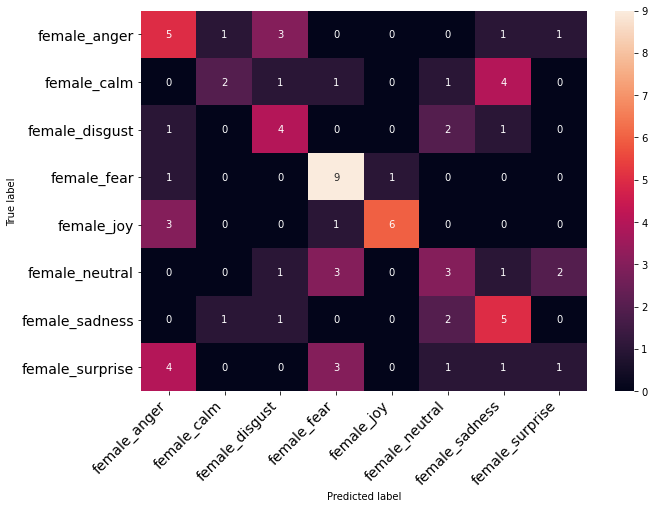

In [ ]:
import seaborn as sns

def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
        
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Gender recode function
def gender(row):
    if row == 'female_disgust' or 'female_fear' or 'female_joy' or 'female_sadness' or 'female_surprise' or 'female_neutral' or 'female_anger' or 'female_calm':
        return 'female'

finaldf = pd.read_csv('Predictions_18_feMALE_8features_realVoice_gabi&stela-mix1.csv')
classes = finaldf.actualvalues.unique()
classes.sort()    

# Confusion matrix 
c = confusion_matrix(finaldf.actualvalues, finaldf.predictedvalues)
#print(accuracy_score(finaldf.actualvalues, finaldf.predictedvalues))
print_confusion_matrix(c, class_names = classes)

# RECORD AUDIO 

In [ ]:
!pip install SpeechRecognition
!pip install pyttsx3
!pip install ffmpeg-python
!sudo apt-get install portaudio19-dev python-pyaudio python3-pyaudio

     |████████████████████████████████| 32.8MB 111kB/s 
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libportaudio2 libportaudiocpp0
Suggested packages:
  portaudio19-doc python-pyaudio-doc
The following NEW packages will be installed:
  libportaudio2 libportaudiocpp0 portaudio19-dev python-pyaudio
  python3-pyaudio
0 upgraded, 5 newly installed, 0 to remove and 14 not upgraded.
Need to get 232 kB of archives.
After this operation, 1,108 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libportaudio2 amd64 19.6.0-1 [64.6 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libportaudiocpp0 amd64 19.6.0-1 [15.1 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 portaudio19-dev amd64 19.6.0-1 [104 kB]
Get:4 http://archive.ubuntu.com/ubuntu bionic/universe amd64 python-pyaudio amd64 0.2.11-1build2 [24.1 kB]


In [ ]:
"""
https://blog.addpipe.com/recording-audio-in-the-browser-using-pure-html5-and-minimal-javascript/
https://stackoverflow.com/a/18650249
https://hacks.mozilla.org/2014/06/easy-audio-capture-with-the-mediarecorder-api/
https://air.ghost.io/recording-to-an-audio-file-using-html5-and-js/
https://stackoverflow.com/a/49019356
"""
from IPython.display import HTML, Audio
from google.colab.output import eval_js
from base64 import b64decode
import numpy as np
from scipy.io.wavfile import read as wav_read
import io
import ffmpeg

AUDIO_HTML = """
<script>
var my_div = document.createElement("DIV");
var my_p = document.createElement("P");
var my_btn = document.createElement("BUTTON");
var t = document.createTextNode("Press to start recording");

my_btn.appendChild(t);
//my_p.appendChild(my_btn);
my_div.appendChild(my_btn);
document.body.appendChild(my_div);

var base64data = 0;
var reader;
var recorder, gumStream;
var recordButton = my_btn;

var handleSuccess = function(stream) {
  gumStream = stream;
  var options = {
    //bitsPerSecond: 8000, //chrome seems to ignore, always 48k
    mimeType : 'audio/webm;codecs=opus'
    //mimeType : 'audio/webm;codecs=pcm'
  };            
  //recorder = new MediaRecorder(stream, options);
  recorder = new MediaRecorder(stream);
  recorder.ondataavailable = function(e) {            
    var url = URL.createObjectURL(e.data);
    var preview = document.createElement('audio');
    preview.controls = true;
    preview.src = url;
    document.body.appendChild(preview);

    reader = new FileReader();
    reader.readAsDataURL(e.data); 
    reader.onloadend = function() {
      base64data = reader.result;
      //console.log("Inside FileReader:" + base64data);
    }
  };
  recorder.start();
  };

recordButton.innerText = "Recording... press to stop";

navigator.mediaDevices.getUserMedia({audio: true}).then(handleSuccess);


function toggleRecording() {
  if (recorder && recorder.state == "recording") {
      recorder.stop();
      gumStream.getAudioTracks()[0].stop();
      recordButton.innerText = "Saving the recording... pls wait!"
  }
}

// https://stackoverflow.com/a/951057
function sleep(ms) {
  return new Promise(resolve => setTimeout(resolve, ms));
}

var data = new Promise(resolve=>{
//recordButton.addEventListener("click", toggleRecording);
recordButton.onclick = ()=>{
toggleRecording()

sleep(2000).then(() => {
  // wait 2000ms for the data to be available...
  // ideally this should use something like await...
  //console.log("Inside data:" + base64data)
  resolve(base64data.toString())

});

}
});
      
</script>
"""

def get_audio():
  display(HTML(AUDIO_HTML))
  data = eval_js("data")
  binary = b64decode(data.split(',')[1])
  
  process = (ffmpeg
    .input('pipe:0')
    .output('pipe:1', format='wav')
    .run_async(pipe_stdin = True, pipe_stdout = True, pipe_stderr = True, quiet = True, overwrite_output = True)
  )
  output, err = process.communicate(input=binary)
  
  riff_chunk_size = len(output) - 8
  # Break up the chunk size into four bytes, held in b.
  q = riff_chunk_size
  b = []
  for i in range(4):
      q, r = divmod(q, 256)
      b.append(r)

  # Replace bytes 4:8 in proc.stdout with the actual size of the RIFF chunk.
  riff = output[:4] + bytes(b) + output[8:]

  sr, audio = wav_read(io.BytesIO(riff))

  return audio, sr

In [ ]:
audio_index = 1

In [ ]:
#audio, sr = get_audio()

In [ ]:
type(audio)

In [ ]:
from scipy.io.wavfile import write

samplerate = 44100; fs = 100
#t = np.linspace(0., 1., samplerate)
#amplitude = np.iinfo(np.int16).max
#data = amplitude * np.sin(2. * np.pi * fs * t)

audio_path = '/content/record_' + str(audio_index)
write(audio_path, samplerate, audio)
audio_index += 1

# **VOICE TEST**

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['all', 'display']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


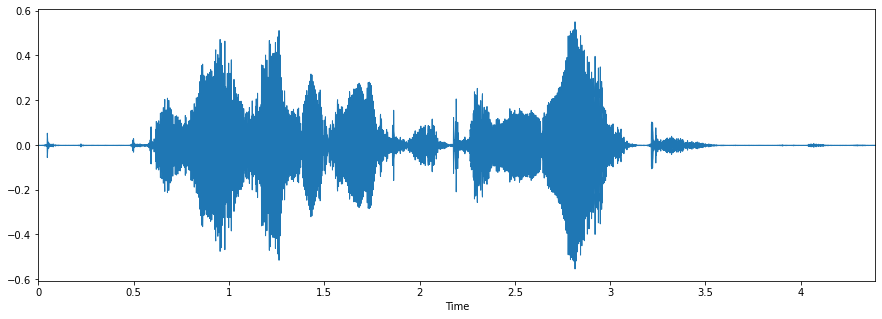

In [ ]:
path = '/content/drive/MyDrive/My_AI/Voice samples-Stela&Gabriela/Stela-disgust-1.m4a'
data, sampling_rate = librosa.load(path)

% pylab inline
import os
import pandas as pd
import librosa
import glob 
from librosa import display

plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)

In [ ]:
X, sample_rate = librosa.load(path, res_type='kaiser_fast',sr=22050) #X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)
sample_rate = np.array(sample_rate)

demo_file = os.fspath(path)
features_live  = extract_feature(demo_file, mel=True, mfcc=True, contrast=True, chroma=True, tonnetz=True, rolloff=True, centroids=True, rms=True)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
features_live = features_live.reshape(-1, 1)
scaler.fit(features_live)
features_live = scaler.transform(features_live)

features_live = pd.DataFrame(data = features_live)
features_live = features_live.stack().to_frame().T

# **EMOTIONS**

In [ ]:
import torch
features_live_2d = np.expand_dims(features_live, axis=2)
live_preds = loaded_model.predict(features_live_2d, batch_size=32, verbose = 1)
print(live_preds)

all = np.argsort(-live_preds, axis=1)[:, :8]
for i in all:
  print((lb.inverse_transform((i))))

print()
print()
best_n = np.argsort(-live_preds)[:, :3]
print(best_n)
print()
print()

for n in best_n:
  print(live_preds[0][n])


for i in best_n:
  print((lb.inverse_transform((i))))

1/1 [==============================] - 0s 19ms/step
[[8.2202649e-05 7.6219216e-03 4.1073994e-04 1.3537318e-02 4.2461365e-01
  1.7594332e-03 5.4985362e-01 2.1210676e-03]]
['female_sadness' 'female_joy' 'female_fear' 'female_calm'
 'female_surprise' 'female_neutral' 'female_disgust' 'female_anger']


[[6 4 3]]


[0.5498536  0.42461365 0.01353732]
['female_sadness' 'female_joy' 'female_fear']


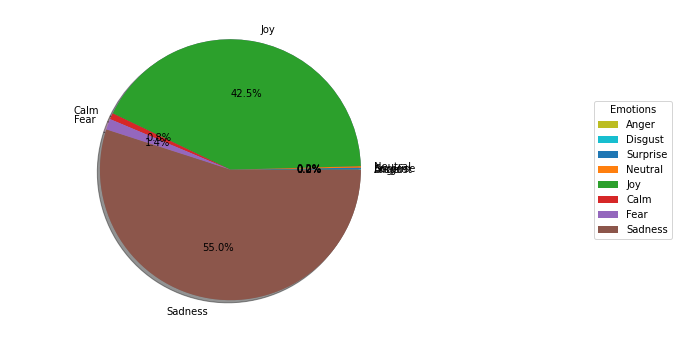

In [ ]:
import matplotlib.pyplot as plt

labels = 'Anger', 'Disgust', 'Surprise', 'Neutral', 'Joy', 'Calm', 'Fear', 'Sadness'
data = [live_preds[0][0], live_preds[0][2], live_preds[0][7], live_preds[0][5],live_preds[0][4], live_preds[0][1], live_preds[0][3],live_preds[0][6]]

fig1, ax1 = plt.subplots(figsize=(8, 6), subplot_kw=dict(aspect="equal"))
ax1.pie(data, labels=labels, autopct='%1.1f%%', shadow=True) 
ax1.axis('equal')  
def func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "".format(pct, absolute)

wedges, texts, autotexts = ax1.pie(data, autopct=lambda pct: func(pct, data), textprops=dict(color="w"))

ax1.legend(wedges, labels,title="Emotions",loc="center right",bbox_to_anchor=(1,0, 0.5, 1))

plt.show()

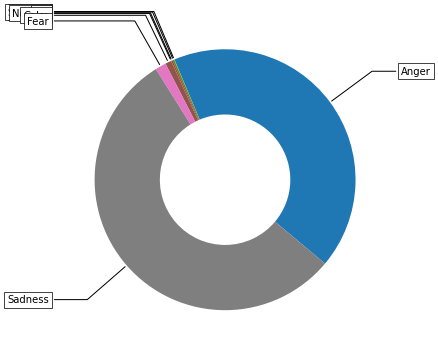

In [ ]:
import matplotlib.pyplot as plt

labels = 'Anger', 'Disgust', 'Surprise', 'Neutral', 'Joy', 'Calm', 'Fear', 'Sadness'
data = [live_preds[0][4], live_preds[0][2], live_preds[0][7], live_preds[0][5],live_preds[0][0], live_preds[0][1], live_preds[0][3],live_preds[0][6]]
fig, ax = plt.subplots(figsize=(8, 6), subplot_kw=dict(aspect="equal"))
wedges, texts = ax.pie(data, wedgeprops=dict(width=0.5), startangle=-40)

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    ax.annotate(labels[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                horizontalalignment=horizontalalignment, **kw)

def func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%\n({:d} g)".format(pct, absolute)

wedges, texts, autotexts = ax1.pie(data, autopct=lambda pct: func(pct, data), textprops=dict(color="w"))

#ax.set_title("Emotion Recognition Result")

plt.show()

In [ ]:
for i in best_n:
  first_emo = lb.inverse_transform((i))[0][5:] ## WRONG
  second_emo = lb.inverse_transform((i))[1][5:]
  third_emo = lb.inverse_transform((i))[2][5:]

emotion = ''
intensity_emo = ''
mixed_emo = ''

if first_second >= 10000:
  emotion = first_emo

elif first_second >= 200:
  #mix intensity
  if first_emo == 'disgust' and second_emo == 'anger': intensity_emo = 'distant' 
  elif first_emo == 'anger' and second_emo == 'disgust': intensity_emo = 'irritation'  
  elif first_emo == 'disgust' and second_emo == 'sadness': intensity_emo = 'guilt'
  elif first_emo == 'sadness' and second_emo == 'disgust': intensity_emo = 'miserable'
  elif first_emo == 'sadness' and second_emo == 'fear': intensity_emo = 'anxious'
  elif first_emo == 'fear' and second_emo == 'sadness': intensity_emo = 'desperate'
  elif first_emo == 'fear' and second_emo == 'joy': intensity_emo = 'astonished'
  elif first_emo == 'joy' and second_emo == 'fear': intensity_emo = 'determined'
  #elif first_emo == '' and second_emo == '': intensity_emo = ''
  #elif first_emo == '' and second_emo == '': intensity_emo = ''

#elif second_third >= 100:
  #mix intensity

if first_second < 200: # in this case the first and second emos are close to equal 
  # mix
  if first_emo == 'disgust' or second_emo == 'disgust':
    if first_emo == 'sadness' or second_emo == 'sadness': emotion = 'remorse'
    elif first_emo == 'neutral' or second_emo == 'neutral': emotion = 'neutral disgust'
    elif first_emo == 'anger' or second_emo == 'anger': emotion = 'contempt'
    elif first_emo == 'fear' or second_emo == 'fear': emotion = 'shame'
    elif first_emo == 'joy' or second_emo == 'joy': emotion = 'morbidness'
    elif first_emo == 'surprise' or second_emo == 'surprise': emotion = 'unbelief'

  elif first_emo == 'fear' or second_emo == 'fear':
    if first_emo == 'neutral' or second_emo == 'neutral': emotion = 'neutral fear'
    elif first_emo == 'joy' or second_emo == 'joy': emotion = 'guilt'         #????
    elif first_emo == 'sadness' or second_emo == 'sadness': emotion = 'despair'
    elif first_emo == 'surprise' or second_emo == 'surprise': emotion = 'awe'
  
  elif first_emo == 'anger' or second_emo == 'anger':
    if first_emo == 'neutral' or second_emo == 'neutral': emotion = 'neutral anger'
    elif first_emo == 'joy' or second_emo == 'joy': emotion = 'pride' 
    elif first_emo == 'surprise' or second_emo == 'surprise': emotion = 'outrage'   

  elif first_emo == 'joy' or second_emo == 'joy':
    if first_emo == 'neutral' or second_emo == 'neutral': emotion = 'neutral joy'  
    elif first_emo == 'surprise' or second_emo == 'surprise': emotion = 'delight' 

  elif first_emo == 'sadness' or second_emo == 'sadness':
    if first_emo == 'neutral' or second_emo == 'neutral': emotion = 'neutral sadness'  
    elif first_emo == 'surprise' or second_emo == 'surprise': emotion = 'disappointment' 
    elif first_emo == 'anger' or second_emo == 'anger': emotion = 'envy'

else: emotion = first_emo

if second_third < 200:    # in this case the second and third emos are close to equal 
 # mix
  if third_emo == 'disgust' or second_emo == 'disgust':
    if third_emo == 'sadness' or second_emo == 'sadness': mixed_emo = 'remorse'
    elif third_emo == 'neutral' or second_emo == 'neutral': mixed_emo = 'neutral disgust'
    elif third_emo == 'anger' or second_emo == 'anger': mixed_emo = 'contempt'
    elif third_emo == 'fear' or second_emo == 'fear': mixed_emo = 'shame'
    elif third_emo == 'joy' or second_emo == 'joy': mixed_emo = 'morbidness'
    elif third_emo == 'surprise' or second_emo == 'surprise': mixed_emo = 'unbelief'

  elif third_emo == 'fear' or second_emo == 'fear':
    if third_emo == 'neutral' or second_emo == 'neutral': mixed_emo = 'neutral fear'
    elif third_emo == 'joy' or second_emo == 'joy': mixed_emo = 'guilt'         #????
    elif third_emo == 'sadness' or second_emo == 'sadness': mixed_emo = 'despair'
    elif third_emo == 'surprise' or second_emo == 'surprise': mixed_emo = 'awe'
  
  elif third_emo == 'anger' or second_emo == 'anger':
    if third_emo == 'neutral' or second_emo == 'neutral': mixed_emo = 'neutral anger'
    elif third_emo == 'joy' or second_emo == 'joy': mixed_emo = 'pride' 
    elif third_emo == 'surprise' or second_emo == 'surprise': mixed_emo = 'outrage'   

  elif third_emo == 'joy' or second_emo == 'joy':
    if third_emo == 'neutral' or second_emo == 'neutral': mixed_emo = 'neutral joy'  
    elif third_emo == 'surprise' or second_emo == 'surprise': mixed_emo = 'delight' 

  elif third_emo == 'sadness' or second_emo == 'sadness':
    if third_emo == 'neutral' or second_emo == 'neutral': mixed_emo = 'neutral sadness'  
    elif third_emo == 'surprise' or second_emo == 'surprise': mixed_emo = 'disappointment' 
    elif third_emo == 'anger' or second_emo == 'anger': mixed_emo = 'envy'


print(first_emo)
print('Main emotion:')
print(emotion)
print('Mixed emotion:')
print(mixed_emo)
print('Emotion by intensity:')
print(intensity_emo)

e_anger
Main emotion:
e_anger
Mixed emotion:

Emotion by intensity:

